## CP-DSAI BCI

For this project, we use SEED dataset obtained from www.bcmi.sjtu.edu.cn . The SEED dataset consists of two parts, Preprocessed_EEG and Extracted_features. In the Preprocessed_EEG folder, the data was downsampled to 200 Hz with applying a bandpass filter from 0-75 Hz. It has 15 subjects each with 15 experiments. In the Extracted_features, it has extracted differential entropy (DE) features of EEG signals.

Since my paper used DE to use it as an input to the model, I used the Extracted_features to test.

In the paper, the proposed model contains three different modules: a sequential features extractor, a domain descriminator and an attention-based encoder-decoder. The sequential features extractor contains LSTM layer to apprehend the features of the EEG recordings. Domain descriminator narrows down the distribution shift. The Attention mechanism improves the model.

### Dataset Creation with Pytorch

In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import os 
import pandas as pd 
import torch
import os
import mne
import torch.nn as nn 

from torch.utils.data import Dataset
from torch.utils.data import random_split

In [2]:
def import_matfiles(path):
    list_mat_ex = os.listdir(path)
    #list_mat_file contains all interessant files for our research
    list_mat_ex.remove('readme.txt')
    #list_mat_file contains all interessant files for our research
    label = 'label.mat'
    print(label)
    list_mat_ex.pop(-1)
    return list_mat_ex, label
    
def find_max_shape(datas, freq = None):
    #shape of data in datas (freq, nb channel, activity)
    if freq == None:
        max_ = datas[0].shape[2]
        for data in datas[1:]:
            act_shape = data.shape[2]
            if act_shape > max_ :
                max_ = act_shape
    else :
        #hape of data in datas (nb channel, activity)
        max_ = datas[0].shape[1]
        for data in datas[1:]:
            act_shape = data.shape[1]
            if act_shape > max_ :
                max_ = act_shape
    return max_  

def x_shaper(x):
    """
    Arg: x as when it outcome from the dataset
    return: x as we wants tensor with (freq, nb_channel, activity)
    """
    x = x.transpose((2, 0, 1))
    return torch.from_numpy(x).type(torch.float32)

def datas_shaper(datas):
    res = []
    for data in datas:
        print(data.shape)
        res.append(x_shaper(data))
    return res 

def padd(datas, freq = None):
    #shape of data in datas (freq, nb channel activity)
    max_shape = find_max_shape(datas, freq =freq)
    res = []
    if freq == None :
        for data in datas:
            aux = torch.zeros((data.shape[0], data.shape[1], max_shape))
            if data.shape[2] < max_shape:
                add_shape = max_shape - data.shape[2]
                for freq in range(data.shape[0]):
                    pad_tensor = torch.zeros((data.shape[1], add_shape))
                    aux[freq, :, :] = torch.cat((data[freq, :, :], pad_tensor), dim=1)
                    aux = aux.type(torch.float32)
                res.append(aux)
            else :
                res.append(data.type(torch.float32))
    else :
        for data in datas:
            aux = torch.zeros((data.shape[0], max_shape))
            if data.shape[1] < max_shape:
                add_shape = max_shape - data.shape[1]
                pad_tensor = torch.zeros((data.shape[0], add_shape))
                aux = torch.cat((data, pad_tensor), dim=1)
                aux = aux.type(torch.float32)
                res.append(aux)
            else :
                res.append(data.type(torch.float32))
    return res

def normalize(x, freq = None):
    if freq == None:
        for frequencies in range(x.shape[0]):
            mean_ = torch.mean(x[frequencies, :, :], 1).reshape(-1, 1)
            std_ = torch.std(x[frequencies, : ,: ], 1).reshape(-1, 1)
            x[frequencies, :, :] = (x[frequencies, :, :] - mean_) / std_
            return x
    else :
        mean_ = torch.mean(x[freq, :, :], 1).reshape(-1, 1)
        std_ = torch.std(x[freq, : ,: ], 1).reshape(-1, 1)
        x[freq, :, :] = (x[freq, :, :] - mean_) / std_
        return x[freq, :, :]

In [3]:
#version to improve in a near future..
class SignalDataset(Dataset):
    def __init__(self, path, signals, subject_number, experiment_number, labels, smoothing_method, freq = None):
        """
        Args: 
            path: path to folder with all the .mat files of the dataset
            signals: feature that we want to extract
            subject_number: subject of the experimenr
            epxeriment_number: number of the experiment, like 0 week 1 week or 2 week 
            (MAYBE I MISUNDERSTOOD THIS PART READ AGAIN DATASET DETAILS)
            labels: labels list
            smoothing method: movingAve or LDS
            freq: 0, 1, 2, 3 or 4 for just specific one and None if you want them all
        """
        list_file, _ = import_matfiles(path)
#         print(list_file)
#         list_file.remove('label.mat')
        #selection of interesting files that means the one related to the subject
        list_sub_file = []
        for file in list_file:
            num = file.split('_')[0]
            if int(num) == subject_number: 
                list_sub_file.append(file)
             
        working_file = list_sub_file[experiment_number]
        
        dic = loadmat(path + '/' + working_file) 
        if smoothing_method == 'movingAve':
            smooth = signals.lower() + '_movingAve'
        elif smooting_method == 'LDS':
            smooth = signals.lower() + '_LDS'
        else :
            raise ValueError('Please select a good smoothing method: movingAve or LDS')
        
        #maybe a list is not the best tool to store it
        datas = []
        for k in range(15):
            sig = dic[smooth + str(k+1)]
            sig = x_shaper(sig)
            sig = normalize(sig, freq = freq) 
            datas.append(sig)
            
        
        datas = padd(datas, freq = freq) #everything is happening in this function, the changement from Long to Float
                                    #and the slicing for the frequency we want

        labels = labels.reshape(-1, )
        labels = labels + 1 
        labels = torch.from_numpy(labels)
                                  
        print(datas[0].shape)                            
        self.datas = datas
        self.labels = labels
    
    def __len__(self):
        return len(self.datas)
    
    def __getitem__(self, idx):
        return self.datas[idx], self.labels[idx].item()

In [4]:
import os
path = r'C:\Users\damia\Documents\CPdsai EEG\ExtractedFeatures\ExtractedFeatures'
l, label_ = import_matfiles(path)
labels = loadmat(path + '/' + label_)['label']
print(labels)

label.mat
[[ 1  0 -1 -1  0  1 -1  0  1  1  0 -1  0  1 -1]]


In [5]:

signals = 'de'
subject_number = 9
experiment_number = 2
labels = labels
smoothing_method = 'movingAve'
dataset = SignalDataset(path, signals, subject_number, experiment_number, labels, smoothing_method, freq = None)
train_dataset, valid_dataset = random_split(dataset, [9, 6])
train_dataset, test_dataset = random_split(dataset, [9,6])

label.mat
torch.Size([5, 62, 265])


In [6]:
print(dataset.datas[0].shape)

torch.Size([5, 62, 265])


In [7]:

print(train_dataset.dataset.datas[0].shape)

torch.Size([5, 62, 265])


In [8]:
BATCH_SIZE = 256 #keeping it binary so it fits GPU
#Train set loader
train_iterator = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

valid_iterator = torch.utils.data.DataLoader(dataset=valid_dataset, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True)

#Test set loader
test_iterator = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True)


In [9]:
# print(train_loader.dataset.dataset.datas[0].shape)

LSTM Model

In [10]:
class LSTM(nn.Module):
    '''
    Expected Input Shape: (batch, len, channels)
    '''
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes, bidirectional, dropout):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, bidirectional=bidirectional, 
                            dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * num_layers, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def attention_net(self, lstm_output, final_state):
        hidden = final_state.unsqueeze(2)  # hidden : [batch_size, n_hidden * num_directions(=2), 1(=n_layer)]
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2) # attn_weights : [batch_size, len, 1]
        soft_attn_weights = F.softmax(attn_weights, 1)
        # [batch_size, n_hidden * num_directions(=2), length] * [batch_size, length, 1] = [batch_size, n_hidden * num_directions(=2), 1]
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        return context, soft_attn_weights.cpu().data.numpy() # context : [batch_size, n_hidden * num_directions(=2)]

    def forward(self, x):
        # Set initial hidden and cell states
        #*2 because it's bidirectional
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(device).float()
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(device).float()
        m,n = x.shape[::2]
        x = torch.reshape(x, (m,-1,n))        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0)) # out: tensor of shape (batch_size, length, hidden_size)
        
        out1, out2 = torch.chunk(out, 2, dim=2)
        out_cat = torch.cat((out1[:, -1, :], out2[:, 0, :]), 1)
        # Decode the hidden state of the last time step
#         out = self.fc(out[:, -1, :]) 
        out = self.softmax(out_cat)
#         out = self.softmax(out)
        return out

In [11]:
input_dim = 62 #62
hidden_dim = 150 #32
num_layers = 2 #2
num_classes = 3 #16
bidirectional = True
dropout = 0.5

#LSTM
model_lstm = LSTM(input_dim, hidden_dim, num_layers, num_classes, bidirectional, dropout)
model_lstm = model_lstm.float() #define precision as float to reduce running time

models = [model_lstm]

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

for model in models:
    print(f'The model {type(model).__name__} has {count_parameters(model):,} trainable parameters')# Train the model

The model LSTM has 800,103 trainable parameters


In [13]:
import torch.optim as optim

learning_rate = 0.001

optimizer = optim.Adam(model.parameters())
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Configured device: ", device)

Configured device:  cpu


In [15]:
for model in models:
    model = model.to(device)
criterion = criterion.to(device)

In [16]:
def train(model, iterator, optimizer, criterion):
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for features, labels in iterator:

#         print(features.shape)
        #Move tensors to the configured device
        features = features.to(device)
        labels = labels.to(device)
        
    
        #Forward pass
        outputs = model(features.float())
#         print(outputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        #check accuracy
        predictions = model(features.float())
        _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
        total += labels.size(0)  #keep track of total
        correct += (predicted == labels).sum().item()  #.item() give the raw number
        acc = 100 * (correct / total)
                
        epoch_loss += loss.item()
        epoch_acc = acc
        
    return epoch_loss / len(iterator), epoch_acc

In [17]:
def evaluate(model, iterator, criterion):
    
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch, labels in iterator:
            
            #Move tensors to the configured device
            batch = batch.to(device)
            labels = labels.to(device)

            predictions = model(batch.float())
            loss = criterion(predictions, labels)

            _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
            total += labels.size(0)  #keep track of total
            correct += (predicted == labels).sum().item()  #.item() give the raw number
            acc = 100 * (correct / total)
            
            epoch_loss += loss.item()
            epoch_acc += acc
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [18]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [30]:
N_EPOCHS = 100

best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

# print(train_iterator.dataset.dataset.datas[0].shape)
for i, model in enumerate(models):
    print(f"Training {type(model).__name__}")
    
    start_time = time.time()

    for epoch in range(N_EPOCHS):
        start_time = time.time()

        train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
        valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)
    
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch: {epoch+1:02}')
            print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
            print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc:.2f}%')

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
#             print("Model:{} saved.".format(type(model).__name__))
            torch.save(model.state_dict(), 'checkpoint.pth.tar')
            best_model_index = i

Training LSTM
Epoch: 10
	Train Loss: 3.763 | Train Acc: 66.67%
	 Val. Loss: 3.917 |  Val. Acc: 50.00%
Epoch: 20
	Train Loss: 3.763 | Train Acc: 55.56%
	 Val. Loss: 3.921 |  Val. Acc: 50.00%
Epoch: 30
	Train Loss: 3.763 | Train Acc: 44.44%
	 Val. Loss: 3.923 |  Val. Acc: 50.00%
Epoch: 40
	Train Loss: 3.763 | Train Acc: 66.67%
	 Val. Loss: 3.924 |  Val. Acc: 50.00%
Epoch: 50
	Train Loss: 3.762 | Train Acc: 44.44%
	 Val. Loss: 3.925 |  Val. Acc: 50.00%
Epoch: 60
	Train Loss: 3.762 | Train Acc: 44.44%
	 Val. Loss: 3.926 |  Val. Acc: 50.00%
Epoch: 70
	Train Loss: 3.762 | Train Acc: 66.67%
	 Val. Loss: 3.926 |  Val. Acc: 50.00%
Epoch: 80
	Train Loss: 3.762 | Train Acc: 44.44%
	 Val. Loss: 3.927 |  Val. Acc: 50.00%
Epoch: 90
	Train Loss: 3.761 | Train Acc: 44.44%
	 Val. Loss: 3.927 |  Val. Acc: 50.00%
Epoch: 100
	Train Loss: 3.761 | Train Acc: 66.67%
	 Val. Loss: 3.927 |  Val. Acc: 50.00%


In [24]:
models[best_model_index].load_state_dict(torch.load('checkpoint.pth.tar'))

test_loss, test_acc = evaluate(models[best_model_index], test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*1:.2f}%')


Test Loss: 3.777 | Test Acc: 16.67%


Text(0, 0.5, 'loss')

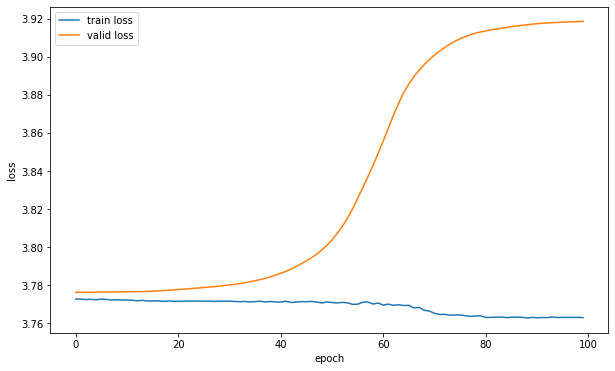

In [27]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

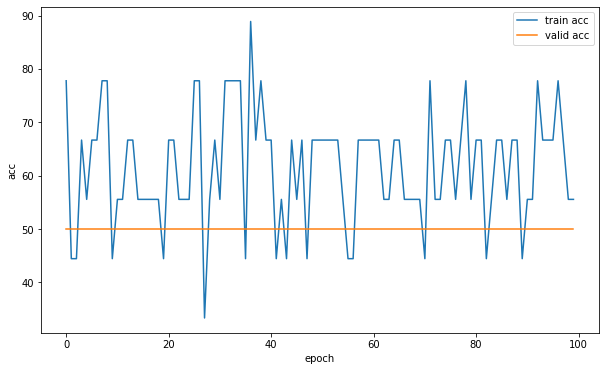

In [28]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

### Testing with all the files

After testing with just one file and got the results, I load all the experiments and run the model again to get the accuracy and loss.

In [31]:

signals = 'de'
labels = labels
smoothing_method = 'movingAve'
for sub in range(1, 15):
    subject_number = sub
    for exp in range(3):
        experiment_number = exp
        dataset = SignalDataset(path, signals, subject_number, experiment_number, labels, smoothing_method, 
                                freq = 0)
        train_dataset, valid_dataset = random_split(dataset, [9, 6])
        train_dataset, test_dataset = random_split(dataset, [9, 6])

label.mat
torch.Size([62, 265])
label.mat
torch.Size([62, 265])
label.mat
torch.Size([62, 265])
label.mat
torch.Size([62, 265])
label.mat
torch.Size([62, 265])
label.mat
torch.Size([62, 265])
label.mat
torch.Size([62, 265])
label.mat
torch.Size([62, 265])
label.mat
torch.Size([62, 265])
label.mat
torch.Size([62, 265])
label.mat
torch.Size([62, 265])
label.mat
torch.Size([62, 265])
label.mat
torch.Size([62, 265])
label.mat
torch.Size([62, 265])
label.mat
torch.Size([62, 265])
label.mat
torch.Size([62, 265])
label.mat
torch.Size([62, 265])
label.mat
torch.Size([62, 265])
label.mat
torch.Size([62, 265])
label.mat
torch.Size([62, 265])
label.mat
torch.Size([62, 265])
label.mat
torch.Size([62, 265])
label.mat
torch.Size([62, 265])
label.mat
torch.Size([62, 265])
label.mat
torch.Size([62, 265])
label.mat
torch.Size([62, 265])
label.mat
torch.Size([62, 265])
label.mat
torch.Size([62, 265])
label.mat
torch.Size([62, 265])
label.mat
torch.Size([62, 265])
label.mat
torch.Size([62, 265])
label.ma

In [32]:
BATCH_SIZE = 64 #keeping it binary so it fits GPU
#Train set loader
train_iterator = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

valid_iterator = torch.utils.data.DataLoader(dataset=valid_dataset, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True)
#Test set loader
test_iterator = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True)


In [33]:
class LSTM(nn.Module):
    '''
    Expected Input Shape: (batch, seq_len, channels)
    '''
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes, bidirectional, dropout):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, bidirectional=bidirectional, 
                            dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * num_layers, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def attention_net(self, lstm_output, final_state):
        hidden = final_state.unsqueeze(2)  # hidden : [batch_size, n_hidden * num_directions(=2), 1(=n_layer)]
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2) # attn_weights : [batch_size, seq_len, 1]
        soft_attn_weights = F.softmax(attn_weights, 1)
        # [batch_size, n_hidden * num_directions(=2), seq_len] * [batch_size, seq_len, 1] = [batch_size, n_hidden * num_directions(=2), 1]
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        return context, soft_attn_weights.cpu().data.numpy() # context : [batch_size, n_hidden * num_directions(=2)]

    def forward(self, x):
        # Set initial hidden and cell states
        #*2 because it's bidirectional
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(device).float()
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(device).float()
        m,n = x.shape[::2]
        x = torch.reshape(x, (m,-1,n))        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0)) # out: tensor of shape (batch_size, seq_length, hidden_size)
        
#         out1, out2 = torch.chunk(out, 2, dim=2)
#         out_cat = torch.cat((out1[:, -1, :], out2[:, 0, :]), 1)
#         out = self.softmax(out_cat)
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :]) 
        
#         out = self.fc(attn_output[:, -1, :]) 
        out = self.softmax(out)
        return out

In [34]:
input_dim = 265
hidden_dim = 4 #32
num_layers = 2 #2
num_classes = 3 #16
bidirectional = True
dropout = 0.5

#LSTM
model_lstm = LSTM(input_dim, hidden_dim, num_layers, num_classes, bidirectional, dropout)
model_lstm = model_lstm.float() #define precision as float to reduce running time

models = [model_lstm]

In [35]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

for model in models:
    print(f'The model {type(model).__name__} has {count_parameters(model):,} trainable parameters')# Train the model

The model LSTM has 9,147 trainable parameters


In [36]:
import torch.optim as optim

learning_rate = 0.01

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Configured device: ", device)

Configured device:  cpu


In [38]:
for model in models:
    model = model.to(device)
criterion = criterion.to(device)

In [39]:
def train(model, iterator, optimizer, criterion):
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for features, labels in iterator:

#         print(features.shape)
        #Move tensors to the configured device
        features = features.to(device)
        labels = labels.to(device)
        
    
        #Forward pass
        outputs = model(features.float())
#         print(outputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        #check accuracy
        predictions = model(features.float())
        _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
        total += labels.size(0)  #keep track of total
        correct += (predicted == labels).sum().item()  #.item() give the raw number
        acc = 100 * (correct / total)
                
        epoch_loss += loss.item()
        epoch_acc = acc
        
    return epoch_loss / len(iterator), epoch_acc

In [40]:
def evaluate(model, iterator, criterion):
    
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch, labels in iterator:
            
            #Move tensors to the configured device
            batch = batch.to(device)
            labels = labels.to(device)

            predictions = model(batch.float())
            loss = criterion(predictions, labels)

            _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
            total += labels.size(0)  #keep track of total
            correct += (predicted == labels).sum().item()  #.item() give the raw number
            acc = 100 * (correct / total)
            
            epoch_loss += loss.item()
            epoch_acc += acc
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [41]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [42]:
N_EPOCHS = 20

best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

# print(train_iterator.dataset.dataset.datas[0].shape)
for i, model in enumerate(models):
    print(f"Training {type(model).__name__}")
    
    start_time = time.time()

    for epoch in range(N_EPOCHS):
        start_time = time.time()

        train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
        valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)
    
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if (epoch+1) % 1 == 0:
            print(f'Epoch: {epoch+1:02}')
            print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
            print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc:.2f}%')

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
#             print("Model:{} saved.".format(type(model).__name__))
            torch.save(model.state_dict(), 'checkpoint.pth.tar')
            best_model_index = i

Training LSTM
Epoch: 01
	Train Loss: 1.078 | Train Acc: 44.44%
	 Val. Loss: 1.085 |  Val. Acc: 33.33%
Epoch: 02
	Train Loss: 1.059 | Train Acc: 55.56%
	 Val. Loss: 1.069 |  Val. Acc: 33.33%
Epoch: 03
	Train Loss: 1.040 | Train Acc: 88.89%
	 Val. Loss: 1.046 |  Val. Acc: 50.00%
Epoch: 04
	Train Loss: 0.996 | Train Acc: 88.89%
	 Val. Loss: 1.030 |  Val. Acc: 50.00%
Epoch: 05
	Train Loss: 0.992 | Train Acc: 88.89%
	 Val. Loss: 1.016 |  Val. Acc: 50.00%
Epoch: 06
	Train Loss: 0.953 | Train Acc: 88.89%
	 Val. Loss: 1.002 |  Val. Acc: 66.67%
Epoch: 07
	Train Loss: 0.939 | Train Acc: 88.89%
	 Val. Loss: 0.984 |  Val. Acc: 66.67%
Epoch: 08
	Train Loss: 0.895 | Train Acc: 100.00%
	 Val. Loss: 0.963 |  Val. Acc: 66.67%
Epoch: 09
	Train Loss: 0.888 | Train Acc: 88.89%
	 Val. Loss: 0.940 |  Val. Acc: 66.67%
Epoch: 10
	Train Loss: 0.871 | Train Acc: 100.00%
	 Val. Loss: 0.913 |  Val. Acc: 66.67%
Epoch: 11
	Train Loss: 0.799 | Train Acc: 100.00%
	 Val. Loss: 0.888 |  Val. Acc: 66.67%
Epoch: 12
	Trai

In [43]:
models[best_model_index].load_state_dict(torch.load('checkpoint.pth.tar'))

test_loss, test_acc = evaluate(models[best_model_index], test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*1:.2f}%')


Test Loss: 0.934 | Test Acc: 66.67%


Text(0, 0.5, 'loss')

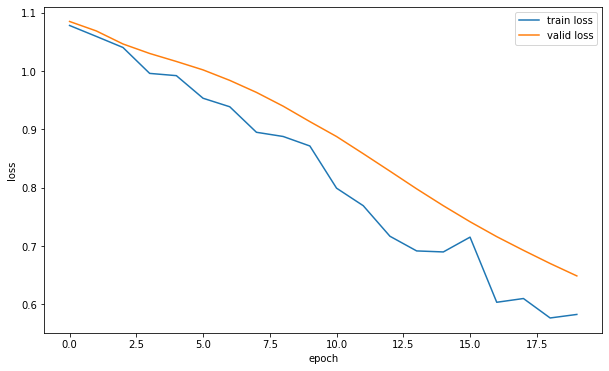

In [44]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

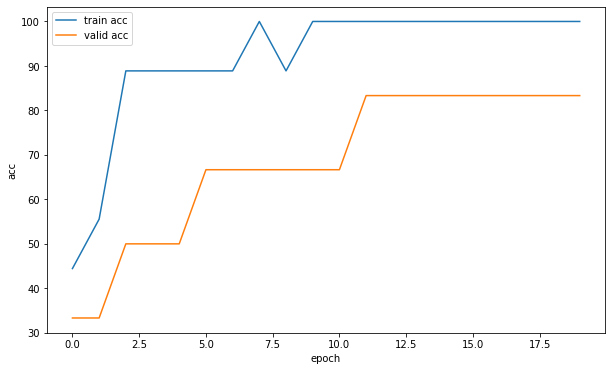

In [45]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('acc')